In [ ]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import scipy.io as io
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
def iemg(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Integrated EMG which is the summation of the absolute values of the EMG signal amplitude.
    It is used as an onset index to detect muscle activity.
    """
    return np.sum(np.abs(data), axis=1)


def mav(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Mean Absolute Value which is the average of the absolute values of the EMG signal.
    It is used for the detection of muscle contraction levels.
    """
    return np.mean(np.abs(data), axis=1)


def mmav1(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Modified Mean Absolute Value 1 which is an extension of the MAV by applying a discrete
    weighting window function.
    """
    llim = int(0.25 * data.shape[1])
    hlim = int(0.75 * data.shape[1]) + 1
    r1 = np.arange(0, llim)
    r2 = np.arange(llim, hlim)
    r3 = np.arange(hlim, data.shape[1])

    return np.mean(np.concatenate((np.abs(np.take(data, r1, axis=1)) * 0.5, np.abs(np.take(data, r2, axis=1)),
                                   np.abs(np.take(data, r3, axis=1)) * 0.5), axis=1), axis=1)


def mmav2(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Modified Mean Absolute Value 2 which is similar to MMAV2 but a smoother continuous
    weighting window function is used.
    """
    llim = int(0.25 * data.shape[1])
    hlim = int(0.75 * data.shape[1]) + 1
    r1 = np.arange(0, llim)
    r2 = np.arange(llim, hlim)
    r3 = np.arange(hlim, data.shape[1])
    c1 = (4 * (r1 + 1) / data.shape[1])[np.newaxis, :, np.newaxis]
    c2 = (4 * (r3 + 1 - data.shape[1]) / data.shape[1])[np.newaxis, :, np.newaxis]

    return np.mean(np.concatenate((np.abs(np.take(data, r1, axis=1)) * c1, np.abs(np.take(data, r2, axis=1)),
                                   np.abs(np.take(data, r3, axis=1)) * c2), axis=1), axis=1)


def mavslp(data):
    """
    :param mavs: Mean Absolute Value of each EMG segment
    :return: The slope/difference of the MAV segments of the EMG signal.
    """
    mavs = mav(data)
    return np.insert(np.diff(mavs, axis=0), 0, 0, axis=0)


def ssi(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Simple Square Integral which is the energy of the sEMG signal segment.
    """
    return np.sum(np.power(np.abs(data), 2), axis=1)


def variance(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Variance which is the average of the square of the signal's deviation from the mean.
    It uses the signals power as a feature.
    """
    return np.var(data, axis=1)


def rms(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Root Mean Square which is the standard deviation of the signal amplitude values.
    It is related to the constant force and non-fatiguing contraction of the muscle.
    """
    return np.sqrt(np.mean(data ** 2, axis=1))


def wl(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Waveform Length which is the cumulative length of the waveform over the time segment.
    It is related to the waveform amplitude, frequency and time.
    """
    return np.sum(np.abs(np.diff(data, axis=1)), axis=1)


def zc2(data, thresh=10):
    """
    :param data: EMG signal samples within rolling window
    :return: Zero Crossing which is the number of times the signal values cross zero.
    It provides an approximation of the signal frequency. The threshold used is for reducing the effect of noise.
    """
    tmp_data = data.copy()
    tmp_data[np.abs(tmp_data) < thresh] = 0
    return np.count_nonzero(np.diff(np.sign(tmp_data), axis=1), axis=1)


def zc(data, th=10):
    """
    :param data: EMG signal samples within rolling window segment
    :param th: Threshold used to reduce noise effects
    :return: Zero Crossing which is the number of times the signal values cross zero.
    It provides an approximation of the signal frequency. The threshold used is for reducing the effect of noise.
    """
    return np.sum((np.diff(np.sign(data), axis=1) != 0) & (np.abs(np.diff(data, axis=1)) > th), axis=1)


def ssc(data, th=10):
    """
    :param data: EMG signal samples within rolling window segment
    :param th: Threshold used to reduce noise effects
    :return: Slope Sign Changes which is the number of changes between positive and negative slopes of the signal.
    It also provides information about the signal frequency. The threshold used is for reducing the effect of noise.
    """
    pos_slope = (-np.diff(data, prepend=1, axis=1) > 0) & (np.diff(data, append=1, axis=1) > 0)
    neg_slope = (-np.diff(data, prepend=1, axis=1) < 0) & (np.diff(data, append=1, axis=1) < 0)
    denoised = (np.abs(-np.diff(data, prepend=1, axis=1)) > th) | (np.abs(np.diff(data, append=1, axis=1)) > th)
    ssc_ = (pos_slope | neg_slope) & denoised
    return np.sum(np.delete(ssc_, [0, -1], axis=1), axis=1)


def wamp(data, th=10):
    """
    :param data: EMG signal samples within rolling window
    :param th: Threshold used to reduce noise effects
    :return: Wilson's Amplitude which is the number of times that the difference between two consecutive signal segments
    passes a certain threshold, which is also used to reduce the effect of noise. WAMP is related to the firing of
    motor unit action potentials (MUAP) and the muscle contraction levels.
    """
    x = np.abs(np.diff(data, axis=1))
    above = x > th
    return np.sum(above, axis=1)


def kurtosis(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Kurtosis which is a statistical measure that defines how the tails of a distribution differs
    from the tails of a normal distribution. It identifies the presence of extreme values in the EMG signal.
    """
    return sp.stats.kurtosis(data, axis=1)


def skewness(data):
    """
    :param data: EMG signal samples within rolling window
    :return: Skewness which measures the lack of symmetry of a distribution. It also identifies the
    presence of extreme values in the EMG signal.
    """
    return sp.stats.skew(data, axis=1)


def sd(data):
    return np.std(data, axis=1)


def mean(data):
    return np.mean(data, axis=1)

In [ ]:
!pip install nitime

     |████████████████████████████████| 6.2 MB 27.8 MB/s 
  Created wheel for nitime: filename=nitime-0.9-cp37-cp37m-linux_x86_64.whl size=4032156 sha256=ab5555e68a4c9e7b07b9c683c76aeb74b5640b301dd11a250ba816a82bc33281
  Stored in directory: /root/.cache/pip/wheels/8e/1b/71/d7d584087121ac331c444b913abeb116b527dad2a0f1d9157a
Successfully built nitime


In [ ]:
from nitime.algorithms.autoregressive import AR_est_YW

def frequency_domain(data, fs, win_len, wind_stride):
    """
    :param data: EMG signal
    :param fs: Sampling frequency of EMG signal
    :param win_len: Number of EMG signal samples per STFT sliding window segment
    :param wind_stride: Number of overlapping samples
    :return: Power Spectrum and Frequency range of the EMG signal resulting from a short time fourier transform
    """
    frequencies, t, fourier_coefficients = signal.stft(data, fs=fs, window='cosine', nperseg=win_len, padded=False,
                                                       noverlap=wind_stride, boundary=None, axis=0)
    power_spectrum = np.square(np.abs(np.transpose(fourier_coefficients, (2, 0, 1))))
    return frequencies, power_spectrum


def ar_coefficients(data, order):
    ak, _ = AR_est_YW(data, order)
    return ak


def mnf(frequencies, power_spectrum):
    """
    :param frequencies: Frequency range of the power spectrum
    :param power_spectrum: Power of the EMG signal at different frequencies
    :return: Mean Frequency which is the average frequency of the power spectrum
    """
    return np.divide(np.sum(np.multiply(power_spectrum, np.repeat(frequencies, power_spectrum.shape[2]).reshape(
        power_spectrum.shape[1], power_spectrum.shape[2])), axis=1), np.sum(power_spectrum, axis=1))


def mdf(frequencies, power_spectrum):
    """
    :param frequencies: Frequency range of the power spectrum
    :param power_spectrum: Power of the EMG signal at different frequencies
    :return: Median Frequency which is the frequency at which the spectrum is divided into two regions with equal power
    """
    med_freq = np.zeros((power_spectrum.shape[0], power_spectrum.shape[2]))
    for indx, segment in enumerate(power_spectrum):
        differences = []
        for ind in range(frequencies.shape[0]):
            diff = np.abs(np.subtract(np.sum(segment[:ind, :], axis=0), 0.5 * np.sum(segment, axis=0)))
            differences.append(diff)

        differences = np.array(differences)
        med_freq[indx, :] = frequencies[differences.argmin(axis=0)]

    return med_freq


def mmnf(frequencies, power_spectrum):
    """
    :param frequencies: Frequency range of the power spectrum
    :param power_spectrum: Power of the EMG signal at different frequencies
    :return: Modified Mean Frequency which uses the amplitude spectrum instead of the power spectrum
    """
    amplitude_spectrum = np.sqrt(power_spectrum)
    return np.divide(np.sum(np.multiply(amplitude_spectrum, np.repeat(frequencies, amplitude_spectrum.shape[2]).reshape(
        amplitude_spectrum.shape[1], amplitude_spectrum.shape[2])), axis=1), np.sum(amplitude_spectrum, axis=1))


def mmdf(frequencies, power_spectrum):
    """
    :param frequencies: Frequency range of the power spectrum
    :param power_spectrum: Power of the EMG signal at different frequencies
    :return: Modified Median Frequency which uses the amplitude spectrum instead of the power spectrum. It
    is the frequency at which the spectrum is divided into two regions with equal amplitude
    """
    amplitude_spectrum = np.sqrt(power_spectrum)
    med_freq = np.zeros((amplitude_spectrum.shape[0], amplitude_spectrum.shape[2]))
    for indx, segment in enumerate(amplitude_spectrum):
        differences = []
        for ind in range(frequencies.shape[0]):
            diff = np.abs(np.subtract(np.sum(segment[:ind, :], axis=0), 0.5 * np.sum(segment, axis=0)))
            differences.append(diff)

        differences = np.array(differences)
        med_freq[indx, :] = frequencies[differences.argmin(axis=0)]

    return med_freq

In [ ]:
supported_features = {"iemg": iemg, "mav": mav,
                      "mmav1": mmav1, "mmav2": mmav2, 
                      "mavslp": mavslp, "ssi": ssi, 
                      "rms": rms, "wl": wl, 
                      "zc": zc, "ssc": ssc, 
                      "wamp": wamp, "kurtosis": kurtosis,
                      "skewness": skewness, "var": variance, 
                      "sd": sd, "mean": mean,
                      "mnf": mnf, "mdf": mdf,
                      "mmnf": mmnf, "mmdf": mmdf}

In [ ]:
def extract_fd(data,fs, win_len, wind_stride, feature_set):
    frequencies, power_spectrum = frequency_domain(data, fs, win_len, wind_stride)

    extracted_features = []
    for feature in feature_set:
        feat_func = supported_features.get(feature.lower(), None)
        if feat_func:
            ex_feat = feat_func(frequencies, power_spectrum)
            extracted_features.append(ex_feat)
        else:
            print(f"Feature {feature} not supported yet")
    if len(extracted_features):
        extracted_features = np.hstack(extracted_features)
    else:
        print("No features have been extracted")
    return extracted_features

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, iirnotch, filtfilt

def load_file(filename):
    mat = io.loadmat(filename)
    data = pd.DataFrame(mat['emg'])
    data['stimulus'] = mat['restimulus']
    data['repetition'] = mat['repetition']
    data['subject'] = mat['subject'].repeat(data.shape[0], axis=0)
    return data

def extract_exercise(file_name):
    ex_num = int(file_name.split(".")[0].split("_")[1][1])
    return ex_num

def get_data(data_dir, exercises=[1,2,3]):
    data = []
    for root, dirs, files in os.walk(data_dir):
        for f in files:
            ex_num = extract_exercise(f)
            if(ex_num in exercises):
                data.append(load_file(os.path.join(root, f)))
    return data

def _butter_highpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
    return b, a

def butter_highpass_filter(data, cutoff=2, fs=200, order=3):
    b, a = _butter_highpass(cutoff=cutoff, fs=fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

def extract_features(rolled_emg, feature_set):
    """
    Extract features from EMG data after rolling window.
    :return: None
    """
    extracted_features = []
    for feature in feature_set:
        feat_func = supported_features.get(feature.lower(), None)
        if feat_func:
            ex_feat = feat_func(rolled_emg)
            extracted_features.append(ex_feat)
        else:
            print(f"Feature {feature} not supported yet")
    if len(extracted_features):
        extracted_features = np.hstack(extracted_features)
    else:
        print("No features have been extracted")
    return extracted_features

def roll_window_op(data, win_len=50, stride=25):
    return sliding_window_view(data, win_len, axis=0)[::stride, :]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = get_data('/content/drive/MyDrive/ninapro-db5', [2])

In [ ]:
# delete this cell (Hady's experiment)
from google.colab import drive
drive.mount('/content/drive')
data = get_data('/content/drive/MyDrive/ninapro-db5', [2])
len(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


10

In [ ]:
data_temp = pd.concat(data)

In [ ]:
data_temp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,stimulus,repetition,subject
0,0.0,-1.0,-1.0,1.0,0.0,-2.0,-2.0,-1.0,0.0,-1.0,0.0,1.0,1.0,0.0,-1.0,0.0,0,0,8
1,0.0,3.0,1.0,-1.0,0.0,0.0,-1.0,4.0,-4.0,-3.0,-1.0,-1.0,-1.0,-2.0,-1.0,-3.0,0,0,8
2,1.0,-1.0,1.0,-2.0,-1.0,-1.0,-2.0,-1.0,0.0,-3.0,-3.0,-2.0,-2.0,-2.0,2.0,3.0,0,0,8
3,-3.0,-2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-2.0,-1.0,0.0,-1.0,-1.0,-2.0,0,0,8
4,-1.0,-1.0,-2.0,0.0,-2.0,-1.0,-2.0,1.0,0.0,-1.0,-3.0,0.0,-3.0,0.0,1.0,3.0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206122,-2.0,0.0,0.0,-2.0,-2.0,-2.0,1.0,2.0,-1.0,1.0,-2.0,-1.0,-1.0,-2.0,-3.0,-5.0,0,6,5
206123,3.0,2.0,0.0,-1.0,0.0,-3.0,0.0,1.0,-1.0,-3.0,-3.0,-1.0,-1.0,1.0,-4.0,-1.0,0,6,5
206124,-4.0,-1.0,-2.0,0.0,-1.0,-2.0,-5.0,-9.0,2.0,1.0,-1.0,0.0,0.0,3.0,6.0,6.0,0,6,5
206125,-4.0,-2.0,-2.0,0.0,-1.0,-2.0,-6.0,-8.0,0.0,-3.0,-3.0,-2.0,-1.0,-1.0,0.0,-1.0,0,6,5


In [ ]:
data_temp[(data_temp.stimulus == 0) & (data_temp.repetition == 2) & (data_temp.subject == 1)][0]

3447     -5.0
3448      6.0
3449     -8.0
3450      2.0
3451     -5.0
         ... 
172615   -2.0
172616   -4.0
172617    4.0
172618   -1.0
172619   -3.0
Name: 0, Length: 6762, dtype: float32

In [ ]:
gesture_mapping = {
    0: "Rest",
    1: "Thumbs Up",
    # 2: "Extension of index and middle, flexion of the others",
    # 3: "Flexion of ring and little finger, extension of the others",
    # 4: "Thumb opposing base of little finger",
    # 5: "Abduction of all fingers",
    6: "Hand Closed",   #"Fingers flexed together in fist",
    7: "Pointing Index",
    8: "Hand Opened",   #"Adduction of Extended Fingers",
    # 9: "Wrist Suppination (axis: middle finger)",
    # 10: "Wrist Pronation (axis: middle finger)",
    # 11: "Wrist Suppination (axis: little finger)",
    # 12: "Wrist Pronation (axis: little finger)",
    13: "Wrist Flexion",
    14: "Wrist Extension",
    # 15: "Wrist Radial Deviation (right)",
    # 16: "Wrist Radial Deviation (left)",
    # 17: "Wrist Extension with Closed Hands"  
}

In [ ]:
n_channels = 16
win_size = 60
rolled_emg = np.empty((0, win_size, n_channels))
rolled_labels = np.empty((0, 1))
rolled_trials = np.empty((0, 1))
for i in range(len(data)):
    all_rolled_trials = roll_window_op(data[i].iloc[:, -2], win_len=win_size, stride=20)
    # Single dataframe contains many trials, so when windowing we want
    # to make sure that there is only one unique trial in the window
    single_trial_idxs = [i for i in range(all_rolled_trials.shape[0]) \
                        if np.unique(all_rolled_trials[i]).shape[0] == 1]

    trial_rolled_trials = all_rolled_trials[single_trial_idxs][:, 0]
    trial_rolled_trials = np.reshape(trial_rolled_trials, (-1, 1))
    
    trial_rolled_emg = np.dstack(roll_window_op(data[i].iloc[:, j], win_len=win_size, stride=20)
                                  for j in range(n_channels))
    trial_rolled_emg = trial_rolled_emg[single_trial_idxs]

    trial_rolled_labels = roll_window_op(data[i].iloc[:, -3], win_len=win_size, stride=20)[:, 0]
    trial_rolled_labels = trial_rolled_labels[single_trial_idxs]
    trial_rolled_labels = np.reshape(trial_rolled_labels, (-1, 1))


    rolled_emg = np.vstack([rolled_emg, trial_rolled_emg])
    rolled_labels = np.vstack([rolled_labels, trial_rolled_labels])
    rolled_trials = np.vstack([rolled_trials, trial_rolled_trials])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()


In [ ]:
print(f"After rolling: emg: {rolled_emg.shape} labels: {rolled_labels.shape} trials: {rolled_trials.shape}")

After rolling: emg: (95170, 60, 16) labels: (95170, 1) trials: (95170, 1)


In [ ]:
labels = rolled_labels[np.isin(rolled_labels, list(gesture_mapping.keys()))]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Frequencies'), Text(0.5, 0, 'Classes')]

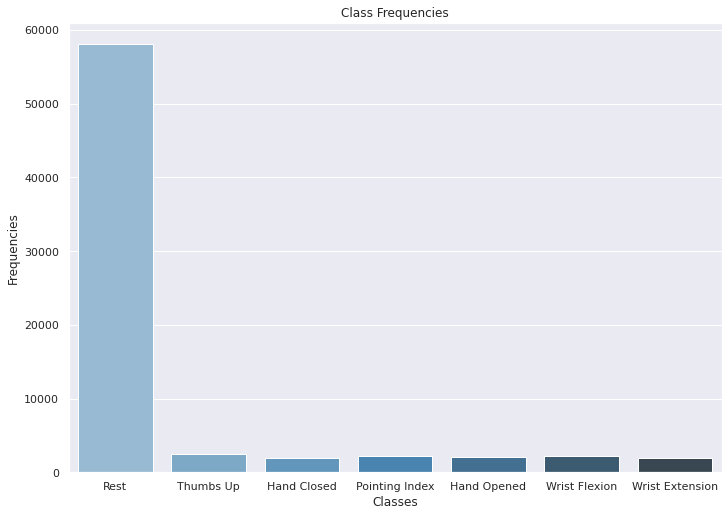

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

unique, counts = np.unique(labels, return_counts=True)
gestures = list(gesture_mapping.values())
class_freq = sns.barplot(gestures, counts, palette="Blues_d")
class_freq.set(title='Class Frequencies')
class_freq.set(xlabel = "Classes", ylabel = "Frequencies")

In [ ]:
hudgins_features = ['mav', 'ssc', 'zc', 'WL']
du_features = ["iEMG", "VAR", "WL", "ZC", "SSC", "WAMP"]
td_features = ["rms", "mav", "mavslp", "zc", "ssc", "wl"]
fd_features = ["mnf", "mdf", "mmnf", "mmdf"]

In [ ]:
train_rows = np.isin(rolled_trials, [1,3,4,6]).ravel()
test_rows = np.isin(rolled_trials, [2, 5]).ravel()


train_emg = rolled_emg[train_rows]
y_train = rolled_labels[train_rows].ravel()

test_emg = rolled_emg[test_rows]
y_test = rolled_labels[test_rows].ravel()

print(f"X_train shape: {train_emg.shape} y_train shape: {y_train.shape}")
print(f"X_test shape: {test_emg.shape} y_test shape: {y_test.shape}")

X_train shape: (39043, 60, 16) y_train shape: (39043,)
X_test shape: (19505, 60, 16) y_test shape: (19505,)


In [ ]:
sub_labels = [0, 1, 6, 7, 8, 13, 14]

train_sub_labels = np.isin(y_train, sub_labels).ravel()
test_sub_labels = np.isin(y_test, sub_labels).ravel()

train_emg_sub_labels = train_emg[train_sub_labels]
y_train_sub_labels = y_train[train_sub_labels]

test_emg_sub_labels = test_emg[test_sub_labels]
y_test_sub_labels = y_test[test_sub_labels]

print(f"X_train shape: {train_emg_sub_labels.shape} y_train shape: {y_train_sub_labels.shape}")
print(f"X_test shape: {test_emg_sub_labels.shape} y_test shape: {y_test_sub_labels.shape}")

X_train shape: (23042, 60, 16) y_train shape: (23042,)
X_test shape: (11488, 60, 16) y_test shape: (11488,)


In [ ]:
y_train_sub_labels[(y_train_sub_labels == 6)] = 2
y_train_sub_labels[(y_train_sub_labels == 7)] = 3
y_train_sub_labels[(y_train_sub_labels == 8)] = 4
y_train_sub_labels[(y_train_sub_labels == 13)] = 5
y_train_sub_labels[(y_train_sub_labels == 14)] = 6


y_test_sub_labels[(y_test_sub_labels == 6)] = 2
y_test_sub_labels[(y_test_sub_labels == 7)] = 3
y_test_sub_labels[(y_test_sub_labels == 8)] = 4
y_test_sub_labels[(y_test_sub_labels == 13)] = 5
y_test_sub_labels[(y_test_sub_labels == 14)] = 6

In [ ]:
np.unique(y_test_sub_labels)

array([0., 1., 2., 3., 4., 5., 6.])

In [ ]:
# raw_emg = pd.concat(data)

In [ ]:
# raw_train_emg = raw_emg[raw_emg.repetition.isin([1,3,4,6])]
# raw_test_emg = raw_emg[raw_emg.repetition.isin([2,5])]

In [ ]:
# train_emg_sub_labels =  raw_train_emg[raw_train_emg.stimulus.isin(sub_labels)]
# test_emg_sub_labels = raw_test_emg[raw_test_emg.stimulus.isin(sub_labels)]

# train_emg_sub_labels = train_emg_sub_labels.drop(["stimulus", "repetition", "subject"], 1)
# test_emg_sub_labels = test_emg_sub_labels.drop(["stimulus", "repetition", "subject"], 1)

In [ ]:
# X_train = extract_fd(train_emg_sub_labels, 200, 60, 10, fd_features)
# X_test = extract_fd(test_emg_sub_labels, 200, 60, 10, fd_features)

X_train = extract_features(train_emg_sub_labels,td_features)
X_test = extract_features(test_emg_sub_labels, td_features)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

rf = RandomForestClassifier(class_weight='balanced', random_state=0)

rf.fit(X_train_scaled, y_train_sub_labels)
test_preds = rf.predict(X_test_scaled)
# acc = accuracy_score(y_test_sub_labels, test_preds)
# balanced_acc = balanced_accuracy_score(y_test_sub_labels, test_preds)
# print("acc", acc)
# print("balanced_acc", balanced_acc)

                 precision    recall  f1-score   support

           Rest       0.91      0.99      0.95      7229
      Thumbs Up       0.91      0.82      0.86       799
    Hand Closed       0.89      0.81      0.85       656
 Pointing Index       0.82      0.68      0.75       733
    Hand Opened       0.79      0.59      0.68       675
  Wrist Flexion       0.84      0.71      0.77       745
Wrist Extension       0.83      0.72      0.77       651

       accuracy                           0.89     11488
      macro avg       0.86      0.76      0.80     11488
   weighted avg       0.89      0.89      0.89     11488



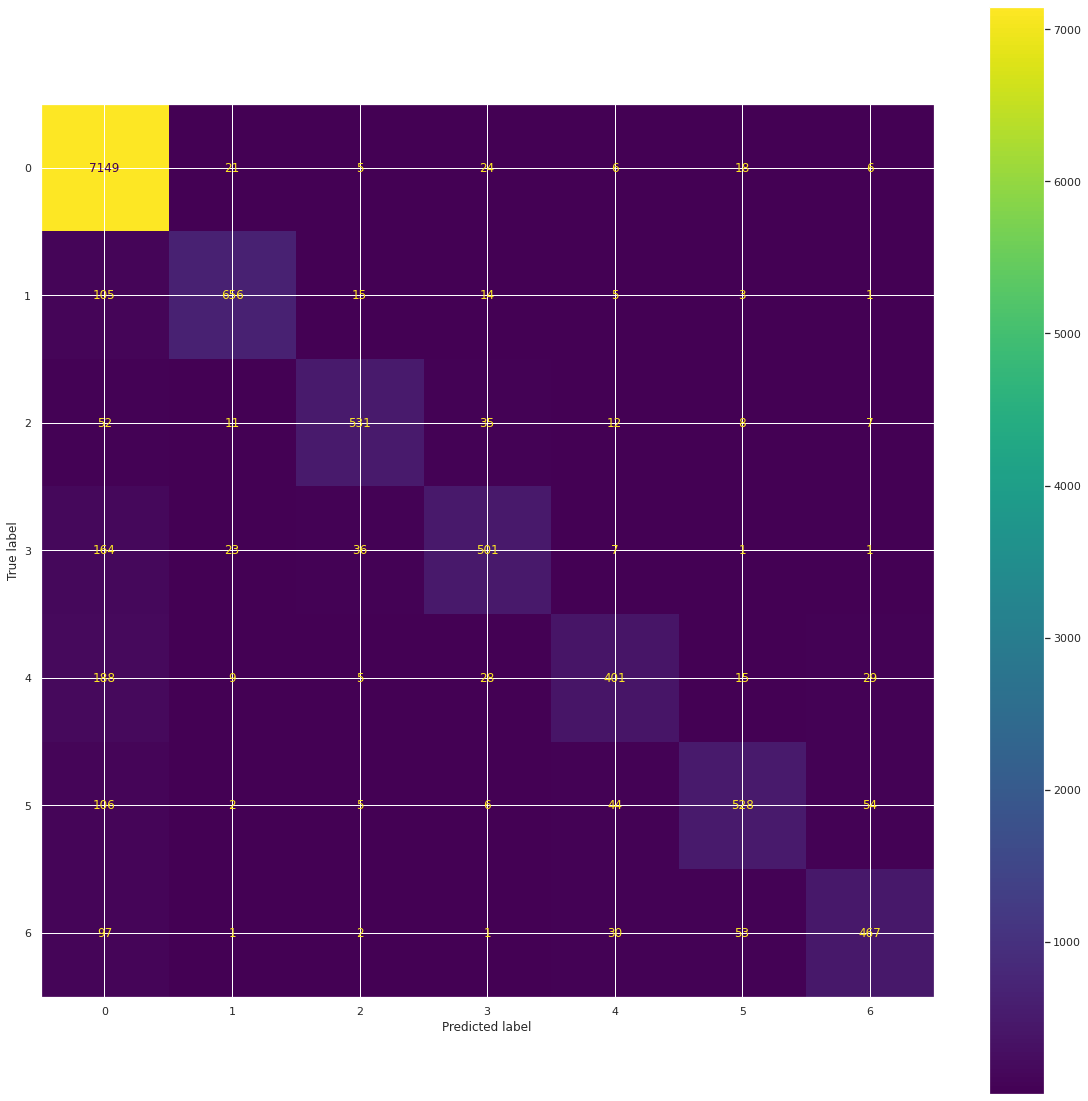

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test_sub_labels, test_preds, target_names=list(gesture_mapping.values())))
cm = confusion_matrix(y_test_sub_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(1,1,figsize=(20,20))
disp.plot(ax=ax)
plt.show()

In [ ]:
import pickle

file = open('rf_model', 'wb')
pickle.dump(rf, file)
file.close()

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', class_weight='balanced', random_state=0)

svm.fit(X_train_scaled, y_train_sub_labels)
test_preds = svm.predict(X_test_scaled)
# acc = accuracy_score(y_test_sub_labels, test_preds)
# balanced_acc = balanced_accuracy_score(y_test_sub_labels, test_preds)
# print("acc", acc)
# print("balanced_acc", balanced_acc)

                 precision    recall  f1-score   support

           Rest       0.96      0.89      0.93      7229
      Thumbs Up       0.67      0.88      0.76       799
    Hand Closed       0.86      0.86      0.86       656
 Pointing Index       0.71      0.81      0.76       733
    Hand Opened       0.61      0.68      0.64       675
  Wrist Flexion       0.73      0.74      0.74       745
Wrist Extension       0.69      0.80      0.74       651

       accuracy                           0.86     11488
      macro avg       0.75      0.81      0.77     11488
   weighted avg       0.87      0.86      0.86     11488



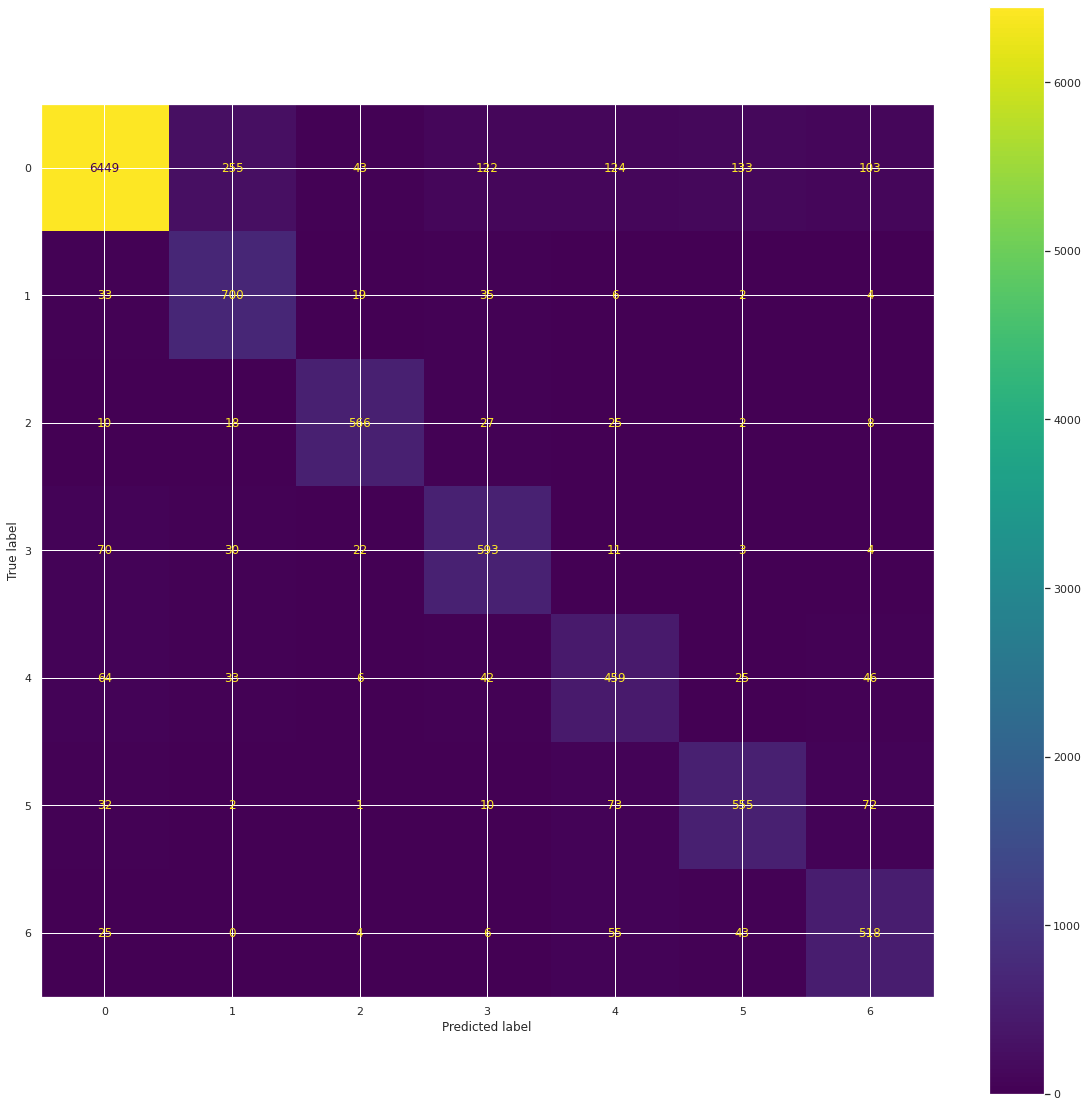

In [ ]:
print(classification_report(y_test_sub_labels, test_preds, target_names=list(gesture_mapping.values())))
cm = confusion_matrix(y_test_sub_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(1,1,figsize=(20,20))
disp.plot(ax=ax)
plt.show()

In [ ]:
file = open('svm_model', 'wb')
pickle.dump(rf, file)
file.close()

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
lr.fit(X_train_scaled, y_train_sub_labels)
test_preds = lr.predict(X_test_scaled)
# acc = accuracy_score(y_test_sub_labels, test_preds)
# balanced_acc = balanced_accuracy_score(y_test_sub_labels, test_preds)
# print("acc", acc)
# print("balanced_acc", balanced_acc)

                 precision    recall  f1-score   support

           Rest       0.96      0.87      0.91      7229
      Thumbs Up       0.56      0.74      0.63       799
    Hand Closed       0.73      0.69      0.71       656
 Pointing Index       0.44      0.59      0.50       733
    Hand Opened       0.40      0.45      0.43       675
  Wrist Flexion       0.56      0.57      0.57       745
Wrist Extension       0.53      0.63      0.57       651

       accuracy                           0.77     11488
      macro avg       0.60      0.65      0.62     11488
   weighted avg       0.80      0.77      0.78     11488



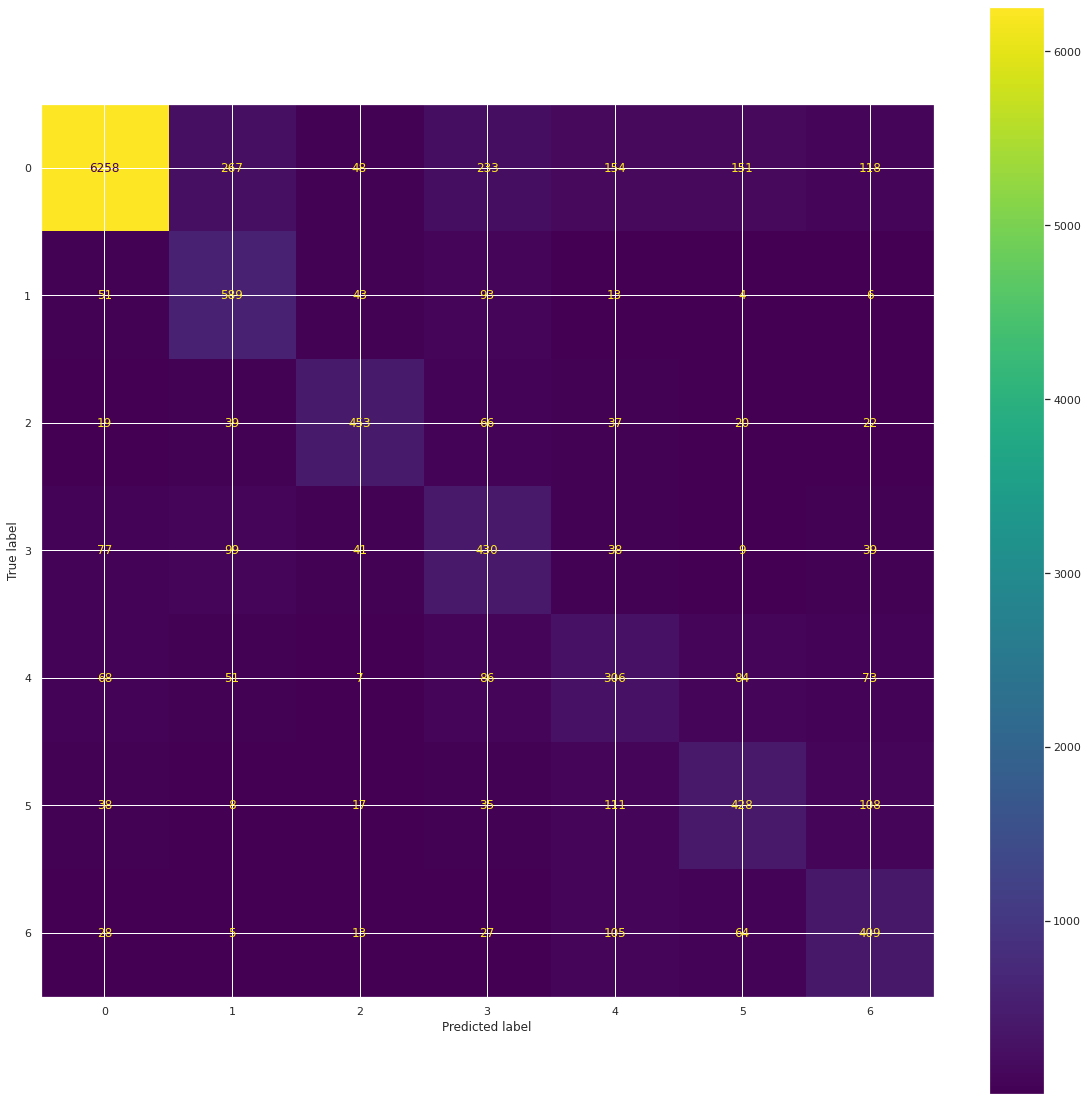

In [ ]:
print(classification_report(y_test_sub_labels, test_preds, target_names=list(gesture_mapping.values())))
cm = confusion_matrix(y_test_sub_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(1,1,figsize=(20,20))
disp.plot(ax=ax)
plt.show()

In [ ]:
file = open('lr_model', 'wb')
pickle.dump(rf, file)
file.close()

In [ ]:
from keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.00001 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % 1 == 0) and (epoch != 0):
        lr = lr * 0.00001
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)

In [ ]:
from keras import callbacks
from keras import Sequential, layers, initializers, optimizers, losses
from tensorflow import keras

model = Sequential()
model.add(layers.Dense(512, kernel_initializer=initializers.HeNormal(), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
# model.summary()

In [ ]:
model_hist = model.fit(X_train_scaled, y_train_sub_labels, validation_data=(X_test_scaled, y_test_sub_labels), batch_size=32, epochs=30)

Epoch 1/30
721/721 [==============================] - 8s 9ms/step - loss: 1.0438 - accuracy: 0.6907 - val_loss: 0.5911 - val_accuracy: 0.8102
Epoch 2/30
721/721 [==============================] - 6s 9ms/step - loss: 0.7162 - accuracy: 0.7765 - val_loss: 0.5009 - val_accuracy: 0.8375
Epoch 3/30
721/721 [==============================] - 6s 8ms/step - loss: 0.6247 - accuracy: 0.8025 - val_loss: 0.4578 - val_accuracy: 0.8511
Epoch 4/30
721/721 [==============================] - 7s 9ms/step - loss: 0.5691 - accuracy: 0.8155 - val_loss: 0.4242 - val_accuracy: 0.8629
Epoch 5/30
721/721 [==============================] - 6s 8ms/step - loss: 0.5207 - accuracy: 0.8299 - val_loss: 0.4055 - val_accuracy: 0.8666
Epoch 6/30
721/721 [==============================] - 6s 9ms/step - loss: 0.4899 - accuracy: 0.8368 - val_loss: 0.3860 - val_accuracy: 0.8724
Epoch 7/30
721/721 [==============================] - 6s 9ms/step - loss: 0.4608 - accuracy: 0.8468 - val_loss: 0.3749 - val_accuracy: 0.8762
Epoch 

In [ ]:
X_test_scaled.shape

(11488, 96)

In [ ]:
# delete this (Hady's experiments)
import timeit
def predict(data_features, model):
    pred_t_start = timeit.default_timer()
    pred = model.predict(data_features)
    pred_t_end = timeit.default_timer()
    print(f'prediction time: {pred_t_end - pred_t_start}')

predict(X_test_scaled[0].reshape((1,-1)), model)

prediction time: 0.2140281199999663


In [ ]:
# import pickle

file = open('dnn_model', 'wb')
pickle.dump(model, file)
file.close()


INFO:tensorflow:Assets written to: ram://6c15cfb0-5bcb-46ad-b969-f64e39ce4598/assets


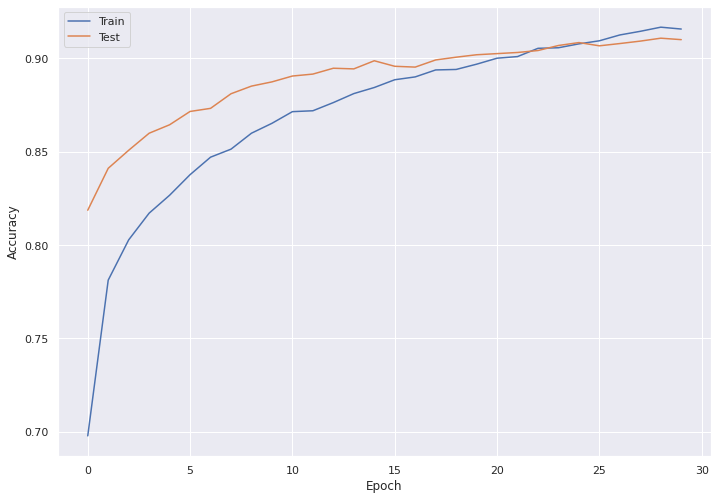

In [ ]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"])

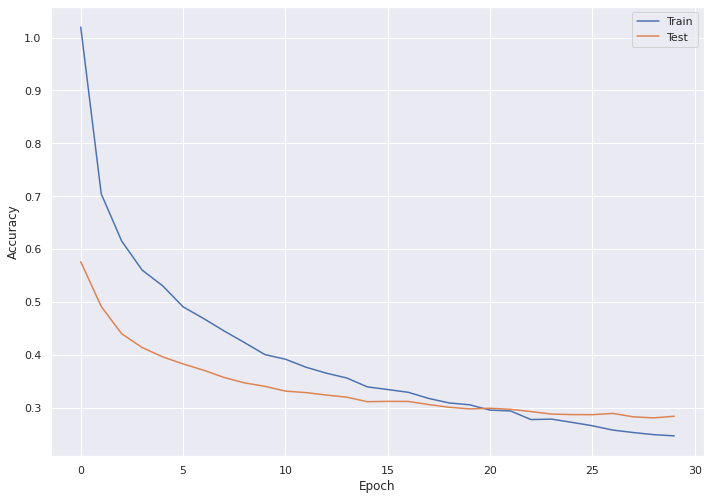

In [ ]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"])

                 precision    recall  f1-score   support

           Rest       0.94      0.98      0.96      7229
      Thumbs Up       0.91      0.83      0.87       799
    Hand Closed       0.86      0.89      0.87       656
 Pointing Index       0.87      0.81      0.84       733
    Hand Opened       0.75      0.70      0.72       675
  Wrist Flexion       0.87      0.75      0.80       745
Wrist Extension       0.83      0.78      0.80       651

       accuracy                           0.91     11488
      macro avg       0.86      0.82      0.84     11488
   weighted avg       0.91      0.91      0.91     11488



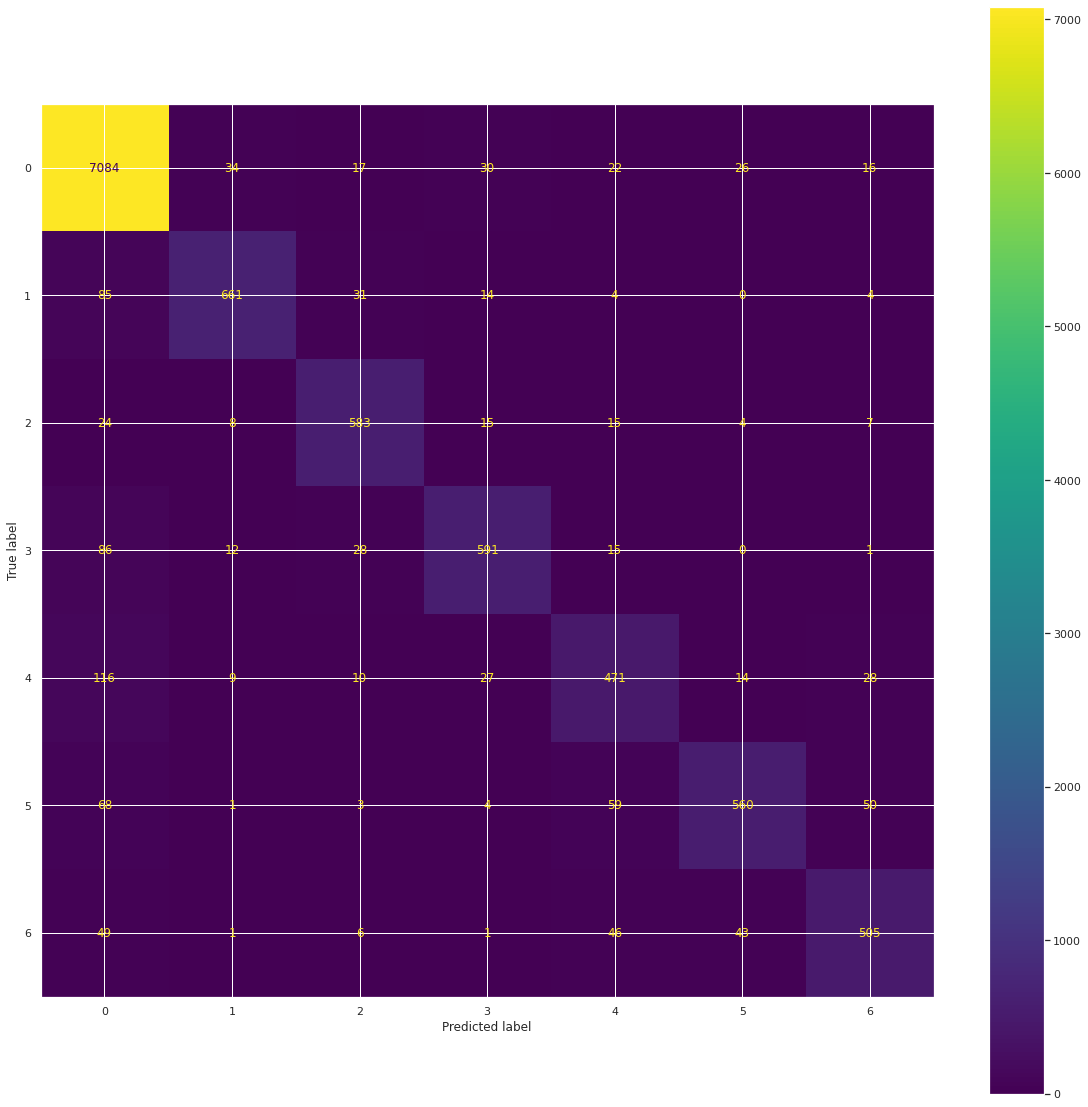

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test_scaled)
print(classification_report(y_test_sub_labels, predictions.argmax(axis=1), target_names=list(gesture_mapping.values())))
cm = confusion_matrix(y_test_sub_labels, predictions.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(1,1,figsize=(20,20))
disp.plot(ax=ax)
plt.show()